In [1]:
!pip install pytorch-fid


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from pytorch_fid import fid_score  # Ensure pytorch-fid is installed


In [3]:
# Generator class
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0),  # Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()  # Normalize output to range [0, 1]
        )

    def forward(self, z):
        return self.model(z)

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),  # Flatten output for the linear layer
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()  # Output: probability between [0, 1]
        )

    def forward(self, x):
        return self.model(x)


In [4]:

# Hyperparameters
latent_dim = 64
learning_rate = 0.0002
batch_size = 720
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Instantiate models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Data loading
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Create directories for FID calculation
real_images_path = '/content/real_images/'
fake_images_path = '/content/fake_images/'
os.makedirs(real_images_path, exist_ok=True)
os.makedirs(fake_images_path, exist_ok=True)

# Save real images for FID comparison
real_image_count = 0
for images, _ in dataloader:
    for idx in range(images.size(0)):
        if real_image_count < 500:  # Save 500 real images
            save_image(images[idx], os.path.join(real_images_path, f"real_image_{real_image_count + 1}.png"), normalize=True)
            real_image_count += 1
        else:
            break
    if real_image_count >= 500:
        break

print(f"Saved {real_image_count} real images to {real_images_path}")

# Training loop
fixed_noise = torch.randn(25, latent_dim, 1, 1).to(device)  # Fixed noise for consistent image generation
g_losses, d_losses = [], []



100%|██████████| 26.4M/26.4M [00:03<00:00, 8.20MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 164kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.05MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.6MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Saved 500 real images to /content/real_images/


100%|██████████| 84/84 [00:11<00:00,  7.43it/s]
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 279MB/s]
100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


FID Score at Epoch 1: 258.3615
Epoch [1/100] | D Loss: 0.6803 | G Loss: 1.8065


100%|██████████| 84/84 [00:07<00:00, 10.78it/s]


Epoch [2/100] | D Loss: 0.9586 | G Loss: 1.1473


100%|██████████| 84/84 [00:07<00:00, 10.51it/s]


Epoch [3/100] | D Loss: 1.1405 | G Loss: 0.9941


100%|██████████| 84/84 [00:08<00:00,  9.96it/s]


Epoch [4/100] | D Loss: 1.0022 | G Loss: 1.3241


100%|██████████| 84/84 [00:07<00:00, 11.69it/s]


Epoch [5/100] | D Loss: 0.9892 | G Loss: 1.3749


100%|██████████| 84/84 [00:08<00:00,  9.52it/s]


Epoch [6/100] | D Loss: 0.9895 | G Loss: 1.3117


100%|██████████| 84/84 [00:07<00:00, 11.56it/s]


Epoch [7/100] | D Loss: 0.8702 | G Loss: 1.3800


100%|██████████| 84/84 [00:08<00:00,  9.54it/s]


Epoch [8/100] | D Loss: 1.0427 | G Loss: 0.8220


100%|██████████| 84/84 [00:07<00:00, 11.47it/s]


Epoch [9/100] | D Loss: 1.0210 | G Loss: 1.0186


100%|██████████| 84/84 [00:08<00:00,  9.34it/s]


Epoch [10/100] | D Loss: 1.1171 | G Loss: 0.7476


100%|██████████| 84/84 [00:08<00:00, 10.33it/s]


Epoch [11/100] | D Loss: 1.1762 | G Loss: 1.6587


100%|██████████| 84/84 [00:07<00:00, 10.77it/s]


Epoch [12/100] | D Loss: 1.0995 | G Loss: 0.6516


100%|██████████| 84/84 [00:08<00:00,  9.44it/s]


Epoch [13/100] | D Loss: 1.0496 | G Loss: 0.9958


100%|██████████| 84/84 [00:07<00:00, 11.43it/s]


Epoch [14/100] | D Loss: 1.0239 | G Loss: 1.0806


100%|██████████| 84/84 [00:09<00:00,  8.90it/s]


Epoch [15/100] | D Loss: 1.0558 | G Loss: 1.0616


100%|██████████| 84/84 [00:07<00:00, 11.65it/s]


Epoch [16/100] | D Loss: 1.2711 | G Loss: 0.7712


100%|██████████| 84/84 [00:08<00:00,  9.51it/s]


Epoch [17/100] | D Loss: 1.0969 | G Loss: 1.1651


100%|██████████| 84/84 [00:08<00:00, 10.40it/s]


Epoch [18/100] | D Loss: 1.0829 | G Loss: 0.9452


100%|██████████| 84/84 [00:07<00:00, 11.11it/s]


Epoch [19/100] | D Loss: 1.0882 | G Loss: 1.0965


100%|██████████| 84/84 [00:08<00:00,  9.45it/s]


Epoch [20/100] | D Loss: 1.1054 | G Loss: 0.8617


100%|██████████| 84/84 [00:07<00:00, 11.39it/s]


Epoch [21/100] | D Loss: 1.1263 | G Loss: 0.8468


100%|██████████| 84/84 [00:08<00:00,  9.48it/s]


Epoch [22/100] | D Loss: 1.1071 | G Loss: 1.0207


100%|██████████| 84/84 [00:07<00:00, 11.30it/s]


Epoch [23/100] | D Loss: 1.1708 | G Loss: 1.2467


100%|██████████| 84/84 [00:08<00:00,  9.69it/s]


Epoch [24/100] | D Loss: 1.2488 | G Loss: 1.4366


100%|██████████| 84/84 [00:08<00:00, 10.09it/s]


Epoch [25/100] | D Loss: 1.1738 | G Loss: 0.9179


100%|██████████| 84/84 [00:08<00:00,  9.34it/s]


Epoch [26/100] | D Loss: 1.1527 | G Loss: 0.9276


100%|██████████| 84/84 [00:08<00:00,  9.43it/s]


Epoch [27/100] | D Loss: 1.2090 | G Loss: 1.1136


100%|██████████| 84/84 [00:07<00:00, 10.93it/s]


Epoch [28/100] | D Loss: 1.2867 | G Loss: 0.6864


100%|██████████| 84/84 [00:08<00:00,  9.78it/s]


Epoch [29/100] | D Loss: 1.1891 | G Loss: 0.9251


100%|██████████| 84/84 [00:08<00:00,  9.76it/s]


Epoch [30/100] | D Loss: 1.1783 | G Loss: 1.1206


100%|██████████| 84/84 [00:07<00:00, 11.18it/s]


Epoch [31/100] | D Loss: 1.2794 | G Loss: 1.3199


100%|██████████| 84/84 [00:08<00:00,  9.40it/s]


Epoch [32/100] | D Loss: 1.1772 | G Loss: 0.9385


100%|██████████| 84/84 [00:07<00:00, 11.49it/s]


Epoch [33/100] | D Loss: 1.1660 | G Loss: 0.8023


100%|██████████| 84/84 [00:08<00:00,  9.61it/s]


Epoch [34/100] | D Loss: 1.2062 | G Loss: 0.7694


100%|██████████| 84/84 [00:07<00:00, 11.17it/s]


Epoch [35/100] | D Loss: 1.2014 | G Loss: 1.3164


100%|██████████| 84/84 [00:08<00:00,  9.65it/s]


Epoch [36/100] | D Loss: 1.2211 | G Loss: 1.0806


100%|██████████| 84/84 [00:08<00:00, 10.14it/s]


Epoch [37/100] | D Loss: 1.2576 | G Loss: 1.2551


100%|██████████| 84/84 [00:07<00:00, 11.25it/s]


Epoch [38/100] | D Loss: 1.1948 | G Loss: 0.9692


100%|██████████| 84/84 [00:10<00:00,  7.70it/s]


Epoch [39/100] | D Loss: 1.2054 | G Loss: 1.0076


100%|██████████| 84/84 [00:07<00:00, 11.46it/s]


Epoch [40/100] | D Loss: 1.2405 | G Loss: 1.2140


100%|██████████| 84/84 [00:08<00:00,  9.45it/s]


Epoch [41/100] | D Loss: 1.1962 | G Loss: 1.1119


100%|██████████| 84/84 [00:07<00:00, 10.87it/s]


Epoch [42/100] | D Loss: 1.2003 | G Loss: 1.0772


100%|██████████| 84/84 [00:08<00:00,  9.81it/s]


Epoch [43/100] | D Loss: 1.2434 | G Loss: 0.7893


100%|██████████| 84/84 [00:08<00:00,  9.74it/s]


Epoch [44/100] | D Loss: 1.2495 | G Loss: 1.2532


100%|██████████| 84/84 [00:07<00:00, 11.15it/s]


Epoch [45/100] | D Loss: 1.2206 | G Loss: 1.1675


100%|██████████| 84/84 [00:09<00:00,  9.30it/s]


Epoch [46/100] | D Loss: 1.2398 | G Loss: 0.9064


100%|██████████| 84/84 [00:07<00:00, 11.58it/s]


Epoch [47/100] | D Loss: 1.1835 | G Loss: 0.8373


100%|██████████| 84/84 [00:08<00:00,  9.45it/s]


Epoch [48/100] | D Loss: 1.1985 | G Loss: 1.2732


100%|██████████| 84/84 [00:07<00:00, 10.98it/s]


Epoch [49/100] | D Loss: 1.2355 | G Loss: 0.8092


100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


FID Score at Epoch 50: 81.4516
Epoch [50/100] | D Loss: 1.1869 | G Loss: 0.9914


100%|██████████| 84/84 [00:07<00:00, 10.74it/s]


Epoch [51/100] | D Loss: 1.1768 | G Loss: 0.7860


100%|██████████| 84/84 [00:08<00:00,  9.93it/s]


Epoch [52/100] | D Loss: 1.1991 | G Loss: 1.1015


100%|██████████| 84/84 [00:08<00:00,  9.71it/s]


Epoch [53/100] | D Loss: 1.1816 | G Loss: 0.9691


100%|██████████| 84/84 [00:07<00:00, 11.35it/s]


Epoch [54/100] | D Loss: 1.2182 | G Loss: 0.9739


100%|██████████| 84/84 [00:08<00:00,  9.33it/s]


Epoch [55/100] | D Loss: 1.2189 | G Loss: 1.0791


100%|██████████| 84/84 [00:07<00:00, 11.59it/s]


Epoch [56/100] | D Loss: 1.2081 | G Loss: 0.8780


100%|██████████| 84/84 [00:08<00:00,  9.53it/s]


Epoch [57/100] | D Loss: 1.2195 | G Loss: 1.0831


100%|██████████| 84/84 [00:07<00:00, 10.98it/s]


Epoch [58/100] | D Loss: 1.2144 | G Loss: 1.0207


100%|██████████| 84/84 [00:09<00:00,  9.16it/s]


Epoch [59/100] | D Loss: 1.1923 | G Loss: 1.1227


100%|██████████| 84/84 [00:09<00:00,  8.62it/s]


Epoch [60/100] | D Loss: 1.1988 | G Loss: 0.8063


100%|██████████| 84/84 [00:07<00:00, 11.54it/s]


Epoch [61/100] | D Loss: 1.2346 | G Loss: 1.1940


100%|██████████| 84/84 [00:08<00:00,  9.37it/s]


Epoch [62/100] | D Loss: 1.4769 | G Loss: 0.6515


100%|██████████| 84/84 [00:07<00:00, 11.34it/s]


Epoch [63/100] | D Loss: 1.2123 | G Loss: 0.8611


100%|██████████| 84/84 [00:08<00:00,  9.45it/s]


Epoch [64/100] | D Loss: 1.1758 | G Loss: 1.0943


100%|██████████| 84/84 [00:08<00:00, 10.45it/s]


Epoch [65/100] | D Loss: 1.2147 | G Loss: 0.9359


100%|██████████| 84/84 [00:08<00:00, 10.45it/s]


Epoch [66/100] | D Loss: 1.2166 | G Loss: 1.1068


100%|██████████| 84/84 [00:08<00:00,  9.56it/s]


Epoch [67/100] | D Loss: 1.1819 | G Loss: 1.0692


100%|██████████| 84/84 [00:07<00:00, 11.55it/s]


Epoch [68/100] | D Loss: 1.2477 | G Loss: 1.1710


100%|██████████| 84/84 [00:08<00:00,  9.42it/s]


Epoch [69/100] | D Loss: 1.2225 | G Loss: 1.4452


100%|██████████| 84/84 [00:07<00:00, 11.58it/s]


Epoch [70/100] | D Loss: 1.2246 | G Loss: 0.7860


100%|██████████| 84/84 [00:08<00:00,  9.48it/s]


Epoch [71/100] | D Loss: 1.2619 | G Loss: 0.7039


100%|██████████| 84/84 [00:07<00:00, 10.69it/s]


Epoch [72/100] | D Loss: 1.2244 | G Loss: 0.8598


100%|██████████| 84/84 [00:09<00:00,  8.43it/s]


Epoch [73/100] | D Loss: 1.1998 | G Loss: 0.8935


100%|██████████| 84/84 [00:08<00:00,  9.47it/s]


Epoch [74/100] | D Loss: 1.2046 | G Loss: 1.0523


100%|██████████| 84/84 [00:07<00:00, 11.42it/s]


Epoch [75/100] | D Loss: 1.2317 | G Loss: 1.3162


100%|██████████| 84/84 [00:08<00:00,  9.52it/s]


Epoch [76/100] | D Loss: 1.2014 | G Loss: 1.3232


100%|██████████| 84/84 [00:07<00:00, 10.95it/s]


Epoch [77/100] | D Loss: 1.3215 | G Loss: 0.6817


100%|██████████| 84/84 [00:08<00:00,  9.76it/s]


Epoch [78/100] | D Loss: 1.2112 | G Loss: 1.2105


100%|██████████| 84/84 [00:08<00:00,  9.90it/s]


Epoch [79/100] | D Loss: 1.2100 | G Loss: 0.8929


100%|██████████| 84/84 [00:07<00:00, 11.23it/s]


Epoch [80/100] | D Loss: 1.1791 | G Loss: 0.9920


100%|██████████| 84/84 [00:08<00:00,  9.51it/s]


Epoch [81/100] | D Loss: 1.2897 | G Loss: 1.2991


100%|██████████| 84/84 [00:07<00:00, 11.38it/s]


Epoch [82/100] | D Loss: 1.2031 | G Loss: 0.9436


100%|██████████| 84/84 [00:08<00:00,  9.60it/s]


Epoch [83/100] | D Loss: 1.1963 | G Loss: 0.9586


100%|██████████| 84/84 [00:07<00:00, 10.79it/s]


Epoch [84/100] | D Loss: 1.1783 | G Loss: 0.9280


100%|██████████| 84/84 [00:08<00:00,  9.85it/s]


Epoch [85/100] | D Loss: 1.2100 | G Loss: 1.2777


100%|██████████| 84/84 [00:08<00:00,  9.89it/s]


Epoch [86/100] | D Loss: 1.2061 | G Loss: 1.2465


100%|██████████| 84/84 [00:07<00:00, 11.41it/s]


Epoch [87/100] | D Loss: 1.1917 | G Loss: 0.9396


100%|██████████| 84/84 [00:08<00:00,  9.39it/s]


Epoch [88/100] | D Loss: 1.1981 | G Loss: 0.9081


100%|██████████| 84/84 [00:07<00:00, 11.48it/s]


Epoch [89/100] | D Loss: 1.1924 | G Loss: 1.0434


100%|██████████| 84/84 [00:08<00:00,  9.46it/s]


Epoch [90/100] | D Loss: 1.1959 | G Loss: 0.8347


100%|██████████| 84/84 [00:07<00:00, 11.24it/s]


Epoch [91/100] | D Loss: 1.2452 | G Loss: 0.7179


100%|██████████| 84/84 [00:08<00:00,  9.43it/s]


Epoch [92/100] | D Loss: 1.2167 | G Loss: 1.0845


100%|██████████| 84/84 [00:08<00:00, 10.05it/s]


Epoch [93/100] | D Loss: 1.2500 | G Loss: 1.1836


100%|██████████| 84/84 [00:07<00:00, 11.14it/s]


Epoch [94/100] | D Loss: 1.2318 | G Loss: 0.8371


100%|██████████| 84/84 [00:08<00:00,  9.38it/s]


Epoch [95/100] | D Loss: 1.2125 | G Loss: 1.1649


100%|██████████| 84/84 [00:08<00:00,  9.45it/s]


Epoch [96/100] | D Loss: 1.1686 | G Loss: 1.0566


100%|██████████| 84/84 [00:08<00:00,  9.44it/s]


Epoch [97/100] | D Loss: 1.1928 | G Loss: 1.0369


100%|██████████| 84/84 [00:08<00:00, 10.44it/s]


Epoch [98/100] | D Loss: 1.2125 | G Loss: 0.9561


100%|██████████| 84/84 [00:08<00:00, 10.19it/s]


Epoch [99/100] | D Loss: 1.2019 | G Loss: 0.8759


100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


FID Score at Epoch 100: 70.5506
Epoch [100/100] | D Loss: 1.1765 | G Loss: 0.9159


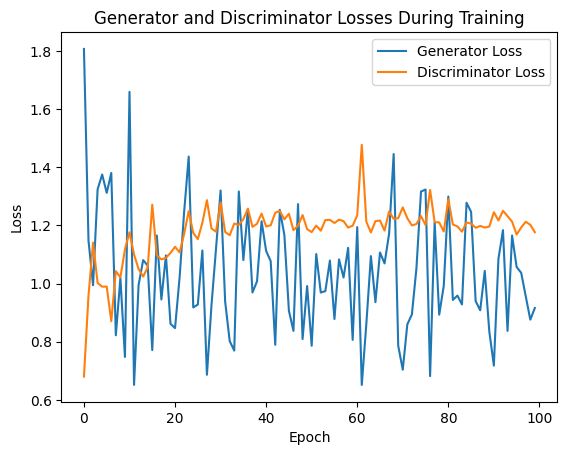

In [5]:
for epoch in range(1, num_epochs + 1):
    for i, (real_images, _) in enumerate(tqdm(dataloader)):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device) * 0.9  # Smoothed labels for real
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ===== Train Discriminator =====
        if i % 2 == 0:
            optimizer_D.zero_grad()
            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)

            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_images = generator(z).detach()
            fake_outputs = discriminator(fake_images)
            d_loss_fake = criterion(fake_outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

        # ===== Train Generator =====
        if i % 2 != 0:
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_images = generator(z)

            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

    # Save losses for plotting
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    # Save generated images and calculate FID at specific epochs
    if epoch in [1, num_epochs//2, num_epochs]:
        with torch.no_grad():
            samples = generator(fixed_noise).detach().cpu()
            save_image(samples, f'generated_images_epoch_{epoch}.png', nrow=5, normalize=True)

        # Save 500 fake images for FID
        fake_image_count = 0
        z = torch.randn(500, latent_dim, 1, 1).to(device)
        fake_images = generator(z).detach().cpu()
        for idx in range(fake_images.size(0)):
            save_image(fake_images[idx], os.path.join(fake_images_path, f"fake_image_{fake_image_count + 1}.png"), normalize=True)
            fake_image_count += 1

        # Compute FID score
        fid = fid_score.calculate_fid_given_paths(
            [real_images_path, fake_images_path],
            batch_size=batch_size,
            device=device,
            dims=2048
        )
        print(f"FID Score at Epoch {epoch}: {fid:.4f}")

    print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Plot loss curves
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Losses During Training')
plt.show()
